# TIX
对未来***某个时间点***，进行价格预测。在到期日时，如果价格到达行权价，合约价格变为$1，否则变为$0。交易杠杆主要有交易所提供的“赔率”***odds***决定  
  
# WIX
属于***美式TIX***。即在到期日之前任意时刻，如果到达行权价都可以立马以$1的价格“行权”  

# 定价
以TIX（“欧式”）为例，vanilla欧式期权的BSM价格为：$c(S, t)=S N\left(d_{1}\right)-K e^{-r(T-t)} N\left(d_{2}\right)$  

$d_{1}=\frac{\ln \left(\frac{S}{K}\right)+(T-t)\left(r+\frac{1}{2} \sigma^{2}\right)}{\sigma \sqrt{T-t}}$  
$d_{2}=\frac{\ln \left(\frac{S}{K}\right)+(T-t)\left(r-\frac{1}{2} \sigma^{2}\right)}{\sigma \sqrt{T-t}}$

由于此二元期权到期收益为：$c(\mathrm{~S}, \mathrm{~T})= \begin{cases}1 & \left(S_{T}>\mathrm{K}\right) \\ 0 & \left(S_{T} \leq \mathrm{K}\right)\end{cases}$  

结合两式，可得WIX价格为：$c(S, t)=e^{-r(T-t)} \cdot N\left(d_{2}\right)$  

# 对冲
1. ***同时发行反方向二元期权***，这也是HXRO trade交易所采取的方式，相当于在产品发行初期便完成了所有对冲工作。是可行性最高的方式。  
   
2. 使用***传统delta对冲***，可通过购入现货或期货构建delta中性，但对于二元期权来说，从$c(S, t)=e^{-r(T-t)} \cdot N\left(d_{2}\right)$ 中得到的delta，在其接近到期且标的价格接近行权价附近时，delta波动会非常剧烈，所以无法准确的对冲。  

# 结论
本质上都属于是二元期权，即达到行权价后获得固定收入/损失。此类期权定价，对冲都足够简单。对于交易所来说，相当于开赌场，只要提供的行权价够多，交易得够分散，总能获得正期望收益  

In [1]:
import sympy as sp
from sympy.stats import Normal, cdf
from py_vollib_vectorized import vectorized_black_scholes
import numpy as np
import matplotlib.pyplot as plt

In [2]:
S, K, sigma, ttm, r, d1, d2 = sp.symbols('S,K,sigma,ttm,r,d_1,d_2')

    # define a symbol to represent the normal CDF
N = sp.Function('N')
    # Black76 price in deri
C = sp.exp(-r * ttm) * N(d2)
# P = N(-d2) * K - F * N(-d1)

    # expanded d1 and d2 for substitution:
d1_sub = (sp.ln(S / K) + ((sp.Rational(1, 2) * sigma ** 2) + r) * ttm) / (sigma * sp.sqrt(ttm))
d2_sub = (sp.ln(S / K) + (r - (sp.Rational(1, 2) * sigma ** 2)) * ttm) / (sigma * sp.sqrt(ttm))

# instance a standard normal distribution:
Norm = Normal('N', 0.0, 1.0)

# define the long form b-s equation with all substitutions:
bs_c = C.subs(N, cdf(Norm)).subs(d2, d2_sub).subs(d1, d1_sub)

# Callable function for black and scholes price:
# example usage: bs_c_calc(100, 98, 0.15, 0.38)
bs_c_calc = sp.lambdify((S, K, sigma, ttm, r), bs_c)

delta_c = sp.simplify(sp.diff(bs_c, S))
delta_c_calc = sp.lambdify((S, K, sigma, ttm, r), delta_c)

bs_c_calc(100, 50, 0.15, 0.38,0.04)
delta_c_calc(100, 100, 0.15, 0.38,0.04)

0.042198247708939485

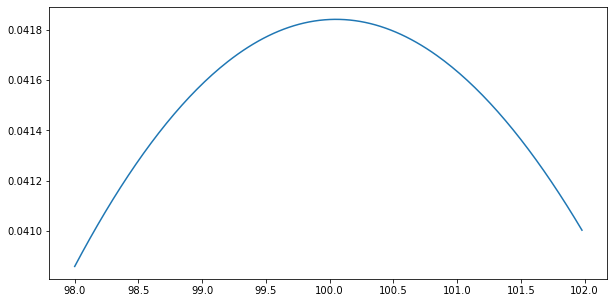

In [4]:
dt = []
for i in np.arange(98,102,0.02):
    dt.append(delta_c_calc(100, i, 0.3, 0.1, 0.05))

plt.figure(figsize=(10,5))
plt.plot(np.arange(98,102,0.02),dt)
plt.show()